In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns

from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'size':16})
import matplotlib.cm as cmap
from multiprocessing import Pool
# from profilestats import profile
from os import listdir, path 
from time import time 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
from funcs.preprocessing.dtdm import dtdm_raw_analysis
from funcs.analysis.analysis import analysis

In [2]:
def plot_stats_property(self, keys, figax, macleod=False, fit=False, fit_g=False, **kwargs):
    subgroup = 10
    if figax is None:
        fig, ax = plt.subplots(1,1, figsize=(18,12))
    else:
        fig, ax = figax
    if keys=='all':
        keys = list(self.pooled_stats.keys())[1:]

    from scipy.optimize import curve_fit
    def func(x, SF_inf, tau, phot_err):
            return (SF_inf*(1 - np.exp(-x/tau)) + phot_err)**0.5
    fitted_params = []
    
    for group_idx in range(self.n_groups):
        if group_idx != subgroup:
            for key in keys:
                y = self.pooled_stats[key][group_idx].T
                color = cmap.jet(group_idx/self.n_groups)
                ax.errorbar(y[0], y[1], yerr=y[2], label=self.label_range_val[group_idx], color=color, capsize=10) # square root this
                ax.scatter(y[0], y[1], color=color)
                if fit:
                    y = self.pooled_stats[key][group_idx].T
                    popt, pcov = curve_fit(func, y[0], y[1])
                    x = np.logspace(0.5,4.2,100)
                    ax.plot(x, func(x, *popt), lw=2, ls='-.', color=color, label=r'$SF_\infty \sqrt {1-e^{-∆t/\tau}}, SF_{\infty}='+'{:.2f},'.format(popt[0])+r'\:\tau'+'={:.2f}$'.format(popt[1])) #fix this
                    print('Slope for {}: {:.2f}'.format(key, popt[1]))
                    fitted_params.append([*popt,*np.diagonal(pcov)])
    
    if fit_g:     
        y_g = np.concatenate(self.pooled_stats[keys[0]], axis=0).T
        popt, pcov = curve_fit(func, y_g[0], y_g[1])
        x = np.logspace(0.7,4.6,100)
        ax.plot(x, func(x, *popt), lw=4, ls='-.', color = 'k', label=r'$SF_\infty \sqrt {1-e^{-∆t/\tau}}, SF_{\infty}='+'{:.2f},'.format(popt[0])+r'\:\tau'+'={:.2f}$'.format(popt[1])) #fix this
    
    ax.legend()
    ax.set(xlabel='Rest frame time lag (days)', title='{}, {}'.format(keys[0], self.obj), **kwargs)

    return fig,ax, np.array(fitted_params)


-2.00 < z < -1.00: 31,001
-1.00 < z < -0.50: 31,167
-0.50 < z < +0.00: 38,717
+0.00 < z < +0.50: 39,266
+0.50 < z < +1.00: 33,018
+1.00 < z < +2.00: 31,444


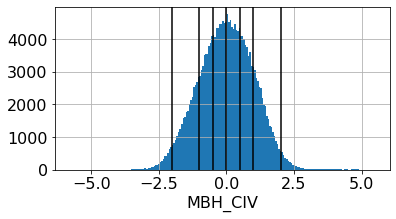

In [3]:
wdir = '/disk1/hrb/python/'
obj = 'qsos'
ID = 'uid'
band = 'r'

dr = analysis(ID, obj)
dr.properties = pd.read_csv(wdir+'data/catalogues/qsos/dr12q/SDSS_DR12Q_BH_matched.csv', index_col=dr.ID)
key = 'MBH_CIV'
prop_range_all = {'Mi':(-30,-20),'mag_mean':(15,23.5),'mag_std':(0,1),'redshift':(0,5),'Lbol':(44,48),'nEdd':(-3,0.5), 'MBH_CIV':(6,12)}
prop_range_any = {key:prop_range_all[key]}
# mask_all = np.array([(bound[0] < dr.properties[key]) & (dr.properties[key] < bound[1]) for key, bound in prop_range_all.items()])
mask_any  = np.array([(bound[0] < dr.properties[key]) & (dr.properties[key] < bound[1]) for key, bound in prop_range_any.items()])
mask = mask_any.any(axis=0)
dr.properties = dr.properties[mask]
# bounds_z = np.array([-2.5,-1.5,-1,-0.5,0,0.5,1,1.5,2.5])
bounds_z = np.array([-2,-1,-0.5,0,0.5,1,2])
bounds_tuple, z_score_val, bounds_values, mean, std, ax = dr.bounds(key, bounds = bounds_z)
z_score = z_score_val['z_score']

np.savetxt(wdir + 'data/computed/qsos/binned/{}/bounds_z.txt'.format(key), bounds_z, fmt='%.2f')
np.savetxt(wdir + 'data/computed/qsos/binned/{}/bounds_values.txt'.format(key), bounds_values)

groups = [z_score_val[(lower < z_score) & (z_score < upper)] for lower, upper in bounds_tuple]
for i, group in enumerate(groups):
    group.to_csv(wdir+'data/computed/{}/binned/{}/uids/group_{}.csv'.format(obj, key, i))

# Shift

In [4]:
dtdm_qsos_civ = dtdm_raw_analysis('qsos', 'uid', 'r', 'qsos')
# dtdm_qsos_civ.calculate_stats_looped_key(26, 'log_dr12', 'MBH_CIV', save=True)
dtdm_qsos_civ.read_pooled_stats('log', key='MBH_CIV')
# dtdm_qsos_lbol.pooled_stats.keys()

In [5]:
centres = (dtdm_qsos_civ.bounds_values[1:] + dtdm_qsos_civ.bounds_values[:-1])/2

y = dtdm_qsos_civ.pooled_stats['SF cwf a'].copy()
x = dtdm_qsos_civ.mjd_centres.copy()
x = np.array([x]*y.shape[0])
y = np.append(x[:, :, np.newaxis],y, axis=-1)

y[:, :, 0] /= 10**((centres[:, np.newaxis]-8)) # -5 for c^3/G and -8 for 10^8 solar mass BH
dtdm_qsos_civ.pooled_stats['SF cwf a'] = y

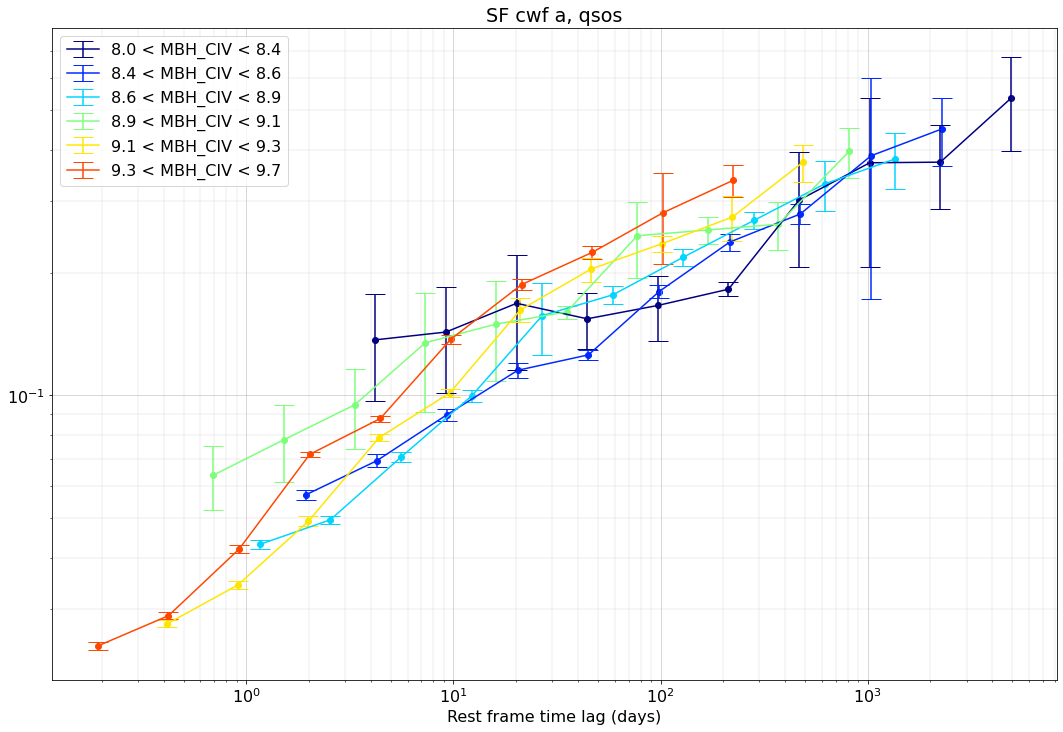

In [6]:
fig, ax, fitted_params = plot_stats_property(dtdm_qsos_civ, ['SF cwf a'], figax=None, fit=False, fit_g=False, xscale='log', yscale='log')
ax.grid(visible=True, which='major', lw=0.5)
ax.grid(visible=True, which='minor', lw=0.2)
# ax.set(ylim=[2e-2, 1], ylabel='Structure Function (mag)', title = 'Structure function (dr12)')
# ax.set(xlabel=r'Rest frame time lag per mass (days/$10^8$M$_\odot$)')
fig.savefig('plots/SF_shift_drw_fit.pdf', bbox_inches='tight')

# Split

In [7]:
def plot_stats_property(self, keys, figax, macleod=False, fit=False, fit_g=False, **kwargs):
    subgroup = 10
    m = 3
    n = 2 
    if figax is None:
        fig, axes = plt.subplots(m,n, figsize=(18,20), sharex=True, sharey=True)
    else:
        fig, ax = figax
    if keys=='all':
        keys = list(self.pooled_stats.keys())[1:]

    from scipy.optimize import curve_fit
    def func(x, tau, var_int, var_phot):
            return (var_int * (1 - np.exp(-(x**(slope*2))/tau)) + var_phot ) ** 0.5
    fitted_params = []
    
    for group_idx, ax in zip(range(self.n_groups), axes.ravel()):
        if group_idx != subgroup:
            for key in keys:
                y = self.pooled_stats[key][group_idx].T
                color = cmap.brg(group_idx/self.n_groups)
                ax.errorbar(y[0], y[1], yerr=y[2], label=self.label_range_val[group_idx], color=color, capsize=10) # square root this
                ax.scatter(y[0], y[1], color=color)
                if fit:
                    y = self.pooled_stats[key][group_idx].T
                    popt, pcov = curve_fit(func, y[0], y[1], p0=[2000, 0.3, 0, 1], bounds=([0, 0, 0, 0], [np.inf, 2, 0.5, 2]))
                    print(popt)
                    x = np.logspace(0.5,4.2,100)
                    ax.plot(x, func(x, *popt), lw=3, ls='-.', color = 'k', label=r'$\sqrt {\sigma_i^2(1-e^{-∆t/\tau}) + \sigma_p^2}, \tau='+'{:.0f},'.format(popt[0])+r'\:\sigma_i'+'={:.2f},'.format(popt[1]**0.5)+r'\:\sigma_p'+'={:.2f}$'.format(popt[2]**0.5)) #fix this
                    fitted_params.append([*popt,*np.diagonal(pcov)])
#                     ax.plot(x, func(x, 5000, 0.3, 0.0001))
                ax.legend(loc=2)
                ax.set(**kwargs)
                ax.grid(visible=True, which='major', lw=0.5)
                ax.grid(visible=True, which='minor', lw=0.2)
                ax.set(ylim=[2e-2, 1])
                
                
    for ax in axes[:, 0]:
        ax.set(ylabel='Structure Function (mag)' )
    for ax in axes[-1, :]:
        ax.set(xlabel='Rest frame time lag (days)')

    
    if fit_g:  
        y_g = np.concatenate(self.pooled_stats[keys[0]], axis=0).T
        popt, pcov = curve_fit(func, y_g[0], y_g[1])
        x = np.logspace(0.7,4.6,100)
        ax.plot(x, func(x, *popt), lw=4, ls='-.', color = 'k', label=r'$SF_\infty \sqrt {1-e^{-∆t/\tau}}, SF_{\infty}='+'{:.2f},'.format(popt[0])+r'\:\tau'+'={:.0f}$'.format(popt[1])) #fix this
    
    plt.subplots_adjust(wspace=0, hspace=0)
#     fig.legend(bbox_to_anchor=(1,0.5)) # For a global legend
    
    return fig,axes, np.array(fitted_params)


In [8]:
dtdm_qsos_civ = dtdm_raw_analysis('qsos', 'uid', 'r', 'qsos')
# dtdm_qsos_civ.calculate_stats_looped_key(26, 'log_dr12', 'MBH_CIV', save=True)
dtdm_qsos_civ.read_pooled_stats('log', key='MBH_CIV')
# dtdm_qsos_lbol.pooled_stats.keys()

In [9]:
centres = (dtdm_qsos_civ.bounds_values[1:] + dtdm_qsos_civ.bounds_values[:-1])/2

y = dtdm_qsos_civ.pooled_stats['SF cwf a']
x = dtdm_qsos_civ.mjd_centres
x = np.array([x]*y.shape[0])
y = np.append(x[:, :, np.newaxis],y, axis=-1)

# y[:, :, 0] /= 10**(1*(centres[:, np.newaxis]-8)) # -5 for c^3/G and -8 for 10^8 solar mass BH
dtdm_qsos_civ.pooled_stats['SF cwf a'] = y

In [10]:
# plotting DRW with systematic photometric error
# x = np.logspace(-2,2)
# y = np.sqrt(10*(1 - np.exp(-x/2))+ 100)
# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.plot(x,y)
# ax.set(xscale='log',yscale='log')

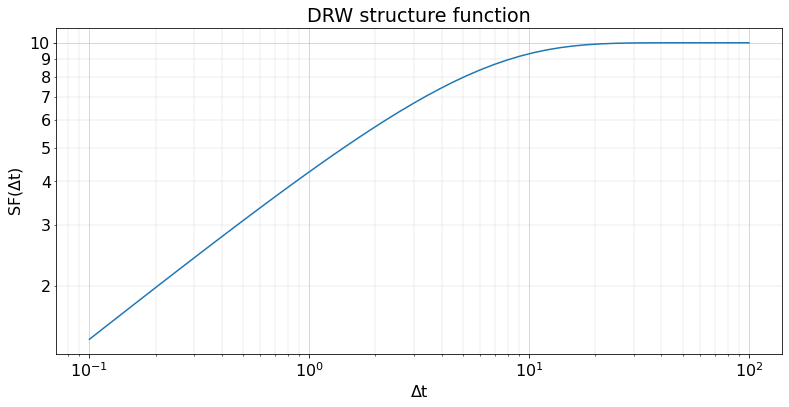

In [11]:
fig, ax = plt.subplots(1,1, figsize = (13,6))
from matplotlib.ticker import FormatStrFormatter
tau = 5
x = np.logspace(-1,2)
y = 10*(1-np.exp(-x/tau)) ** 0.5

ax.plot(x,y)
ax.set(xscale='log', yscale='log', xlabel=r'$\Delta$t', ylabel=r'SF($\Delta$t)', title='DRW structure function')
ax.grid(visible=True, which='major', lw=0.5)
ax.grid(visible=True, which='minor', lw=0.2)
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.savefig('plots/drw_sf.pdf', bbox_inches='tight')

[1.54304640e+03 6.56234720e-01 1.67736455e-02 3.72635703e-01]
[7.81208274e+02 3.20735109e-01 2.00990239e-03 3.73913522e-01]
[3.06690509e+02 1.73440516e-01 8.86348794e-18 3.52123557e-01]
[1.05958678e+03 2.00000000e+00 1.61401832e-35 2.42842772e-01]
[6.79260639e+02 2.02504297e-01 6.22275795e-20 3.68087241e-01]
[9.61578447e+02 1.27819015e-01 3.72785453e-22 4.24984903e-01]


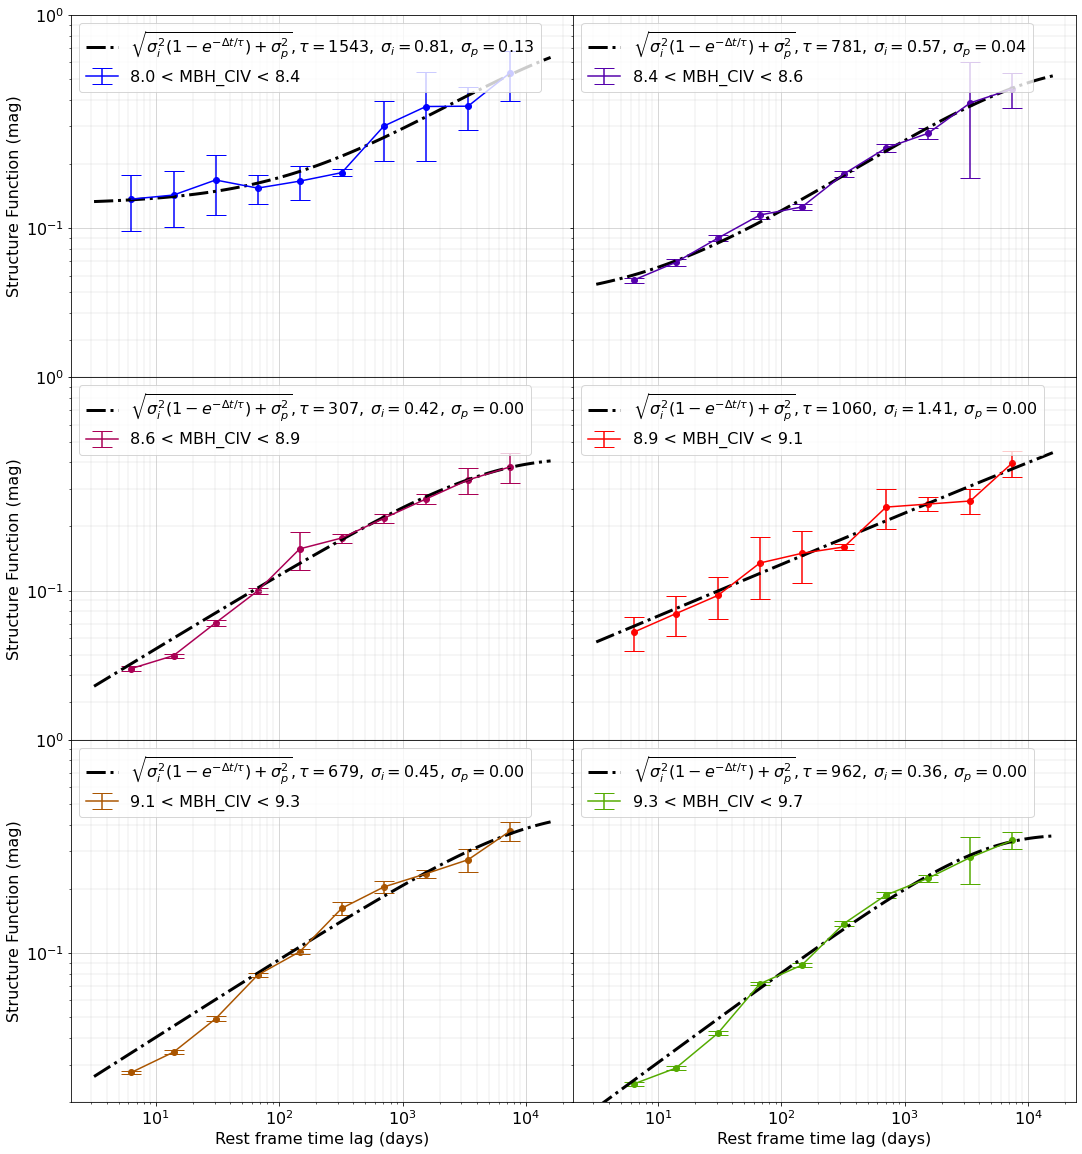

In [21]:
fig, ax, fitted_params = plot_stats_property(dtdm_qsos_civ, ['SF cwf a'], figax=None, fit=True, fit_g=False, xscale='log', yscale='log')
# ax.set(xlabel=r'Rest frame time lag per mass (days/$10^8$M$_\odot$)')
fig.savefig('plots/SF_split_fit_phot_err_modified.pdf', bbox_inches='tight')

In [15]:
fitted_params.shape

(6, 8)

[Text(0.5, 0, 'Black hole mass / (log$_{10}$M$_\\odot$)'),
 Text(0, 0.5, '$\\tau$ (days)')]

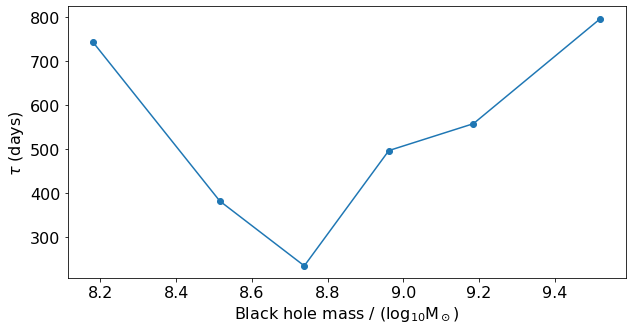

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.errorbar(centres, fitted_params[:,0], yerr=fitted_params[:,4],capsize=10)
ax.errorbar(centres, fitted_params[:,0],capsize=10)
ax.scatter(centres, fitted_params[:,0])
ax.set(xlabel=r'Black hole mass / (log$_{10}$M$_\odot$)', ylabel=r'$\tau$ (days)')
# fig.savefig('plots/SFinf_Mbh.pdf',bbox_inches='tight')

[Text(0.5, 0, 'Black hole mass / (log$_{10}$M$_\\odot$)'),
 Text(0, 0.5, '$\\sigma_i$ (mag)')]

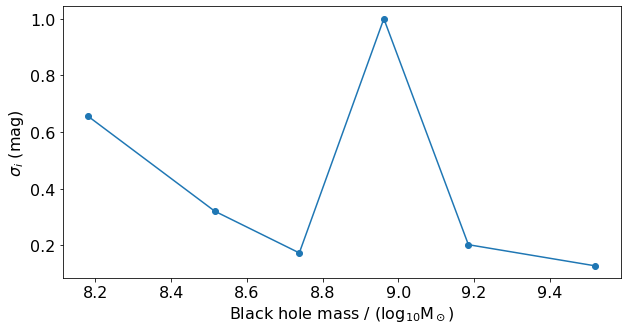

In [385]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.errorbar(centres, fitted_params[:,1], yerr=fitted_params[:,5],capsize=10)
ax.errorbar(centres, fitted_params[:,1],capsize=10)
ax.scatter(centres, fitted_params[:,1])
ax.set(xlabel=r'Black hole mass / (log$_{10}$M$_\odot$)', ylabel=r'$\sigma_i$ (mag)')
# fig.savefig('plots/SFinf_Mbh.pdf',bbox_inches='tight')

[Text(0.5, 0, 'Black hole mass / (log$_{10}$M$_\\odot$)'),
 Text(0, 0.5, '$\\sigma_p$ (mag)')]

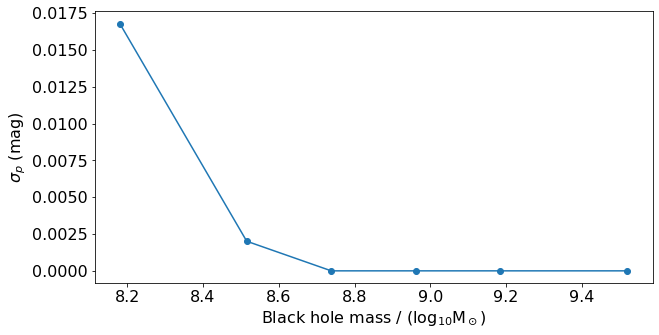

In [386]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.errorbar(centres, fitted_params[:,2], yerr=fitted_params[:,6],capsize=10)
ax.errorbar(centres, fitted_params[:,2], capsize=10)
ax.scatter(centres, fitted_params[:,2])
ax.set(xlabel=r'Black hole mass / (log$_{10}$M$_\odot$)', ylabel=r'$\sigma_p$ (mag)')
# fig.savefig('plots/SFinf_Mbh.pdf',bbox_inches='tight')

[Text(0.5, 0, 'Black hole mass / (log$_{10}$M$_\\odot$)'),
 Text(0, 0.5, 'slope')]

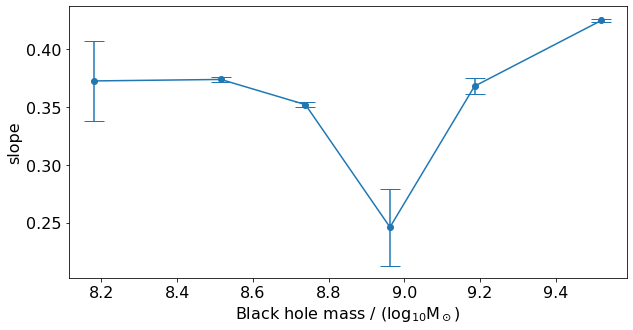

In [382]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.errorbar(centres, fitted_params[:,3], yerr=fitted_params[:,7],capsize=10)
ax.scatter(centres, fitted_params[:,3])
ax.set(xlabel=r'Black hole mass / (log$_{10}$M$_\odot$)', ylabel=r'slope')
# fig.savefig('plots/SFinf_Mbh.pdf',bbox_inches='tight')